
# Project: Brain Segmentation Project 

# Data Preparation

## 1. Downloading the Dataset

The MRI dataset was obtained from [this Google Drive link](https://drive.google.com/drive/folders/1HqEgzS8BV2c7xYNrZdEAnrHk7osJJ--2). This dataset comprises MRI images of the brain in nii.gz format. The dataset includes scans from various patients with different conditions, providing a diverse range of brain images for segmentation tasks.

## 2. Displaying Sample Data

To gain insight into the structure and quality of the dataset, a few sample images were extracted and visualized. This step helped ensure data integrity and assess any preprocessing requirements before proceeding with segmentation tasks.



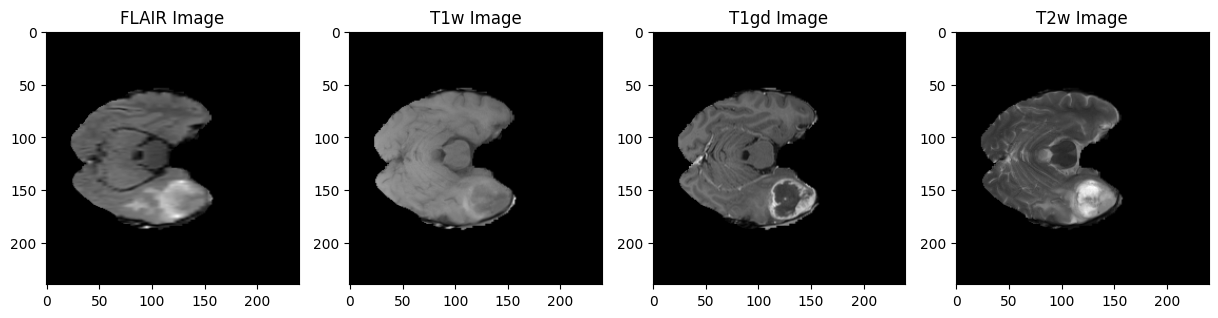

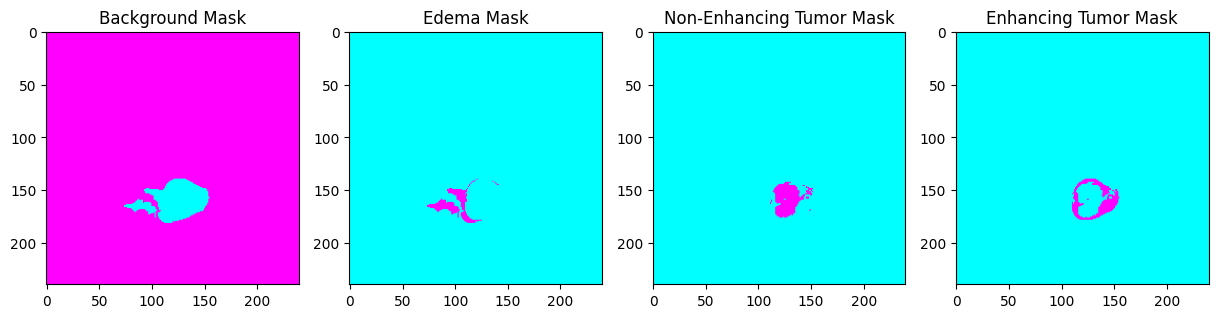

In [78]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Load a sample image and label
image_path = "imagesTr/BRATS_001.nii.gz"
label_path = "labelsTr/BRATS_001.nii.gz"

image_data = nib.load(image_path).get_fdata()
label_data = nib.load(label_path).get_fdata()

# Access specific modalities (e.g., FLAIR, T1w, etc.)
flair_volume = image_data[..., 0]
t1w_volume = image_data[..., 1]
t1gd_volume = image_data[..., 2]
t2w_volume = image_data[..., 3]

# Access label information
background_mask = (label_data == 0)
edema_mask = (label_data == 1)
non_enhancing_tumor_mask = (label_data == 2)
enhancing_tumor_mask = (label_data == 3)

# Example: Visualize FLAIR and label overlay
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(flair_volume[:, :, 50], cmap='gray')
plt.title("FLAIR Image")

plt.subplot(1, 4, 2)
plt.imshow(t1w_volume[:, :, 50], cmap='gray')
plt.title("T1w Image")

plt.subplot(1, 4, 3)
plt.imshow(t1gd_volume[:, :, 50], cmap='gray')
plt.title("T1gd Image")

plt.subplot(1, 4, 4)
plt.imshow(t2w_volume[:, :, 50], cmap='gray')
plt.title("T2w Image")

plt.show()

# Visualize labels
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(background_mask[:, :, 50], cmap='cool', vmin=0, vmax=1)
plt.title("Background Mask")

plt.subplot(1, 4, 2)
plt.imshow(edema_mask[:, :, 50], cmap='cool', vmin=0, vmax=1)
plt.title("Edema Mask")

plt.subplot(1, 4, 3)
plt.imshow(non_enhancing_tumor_mask[:, :, 50], cmap='cool', vmin=0, vmax=1)
plt.title("Non-Enhancing Tumor Mask")

plt.subplot(1, 4, 4)
plt.imshow(enhancing_tumor_mask[:, :, 50], cmap='cool', vmin=0, vmax=1)
plt.title("Enhancing Tumor Mask")

plt.show()



# Segmentation Task

## Preprocessing:

Standard preprocessing techniques were applied, including normalization, resizing, and possibly skull stripping or intensity normalization to enhance segmentation accuracy.

In [3]:
import numpy as np
import nibabel as nib
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
def load_and_preprocess_data(image_path, label_path):
    # Load training image
    img_tr = nib.load(image_path).get_fdata()
    # Load training label
    label_tr = nib.load(label_path).get_fdata()

    # Normalize image
    img_tr /= img_tr.max()

    # Define the target depth dimension
    target_depth = 240

    # Check the current depth dimension
    current_depth = img_tr.shape[2]

    # Calculate padding or cropping amounts
    depth_diff = target_depth - current_depth
    padding = (0, 0) if depth_diff <= 0 else (0, depth_diff)

    # Pad or crop volumes to match the target depth dimension
    if depth_diff < 0:  # Crop volumes
        img_tr = img_tr[:, :, :target_depth, :]
        label_tr = label_tr[:, :, :target_depth]
    else:  # Pad volumes
        img_tr = np.pad(img_tr, ((0, 0), (0, 0), (0, depth_diff), (0, 0)), mode='constant')
        label_tr = np.pad(label_tr, ((0, 0), (0, 0), (0, depth_diff)), mode='constant')

    # Get dimensions
    height, width, depth, channels = img_tr.shape

    return img_tr, label_tr, height, width, depth, channels

## Applying U-Net for Segmentation:

Once the data is prepared, the U-Net model, a popular choice for medical image segmentation, is applied for segmenting the brain images. U-Net is known for its effectiveness in capturing intricate image details and producing accurate segmentations. The steps involved include:

Model Training: The U-Net model is trained on the preprocessed MRI dataset. Training involves feeding the model with input MRI images and their corresponding ground truth segmentation masks.

Validation and Tuning: The model's performance is evaluated on a validation set, and hyperparameters are fine-tuned to optimize segmentation accuracy.

Segmentation: After training, the trained U-Net model is used to segment new brain MRI images, producing segmentation masks highlighting the brain regions.

In [4]:
def unet(input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Decoder
    up1 = UpSampling2D(size=(2, 2))(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(up1)
    concat1 = Concatenate()([conv2, conv1])

    # Output
    outputs = Conv2D(1, 1, activation='sigmoid')(concat1)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [5]:
model = unet((256, 256, 3))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 256, 256,  │          0 │ max_pooling2d[0]… │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ up_sampling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256, 256,  │          0 │ conv2d_1[0][0],   │
│ (Concatenate)       │ 128)              │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │        129 │ concatenate[0][0] │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,849 (151.75 KB)

 Trainable params: 38,849 (151.75 KB)

 Non-trainable params: 0 (0.00 B)

## Visualizing Segmentation Results

Finally, the segmentation results are visualized to assess the performance of the U-Net model. Visualization helps in understanding how well the model has segmented the brain images and identifying any areas for improvement. This involves:

Displaying Original Images: Original MRI images are displayed alongside their corresponding segmentation masks.

Assessing Segmentation Accuracy: The segmentation maps are visually inspected to determine the accuracy of the segmentation. Any discrepancies or inaccuracies are noted for further refinement if needed.

Comparing Segmentation Results: Multiple pairs of original images and their segmentation maps are presented to showcase the consistency and effectiveness of the segmentation method.

In [68]:
import matplotlib.pyplot as plt

# Function to visualize segmentation results
def visualize_segmentation(image_path, label_path, slice_index):
    # Load and preprocess data
    img_tr, label_tr, height, width, depth, channels = load_and_preprocess_data(image_path, label_path)

    # Create and train U-Net model
    model = unet(input_shape=(height, width, channels))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(img_tr, label_tr, epochs=10, validation_split=0.2)

    # Predict segmentation mask for the original image
    segmentation_mask = model.predict(img_tr)

    # Plot original image and segmented image side by side
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_tr[:, :, slice_index, 0], cmap='gray')
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(segmentation_mask[:, :, slice_index, 0], cmap='gray')
    plt.title("Segmented Image")

    plt.show()


## Segmentation Applied On Train Image1

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.9877 - loss: 0.6784 - val_accuracy: 1.0000 - val_loss: 0.6524
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.9898 - loss: 0.6156 - val_accuracy: 1.0000 - val_loss: 0.5674
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.9907 - loss: 0.5246 - val_accuracy: 1.0000 - val_loss: 0.4395
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.9900 - loss: 0.4111 - val_accuracy: 1.0000 - val_loss: 0.2858
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.9896 - loss: 0.2678 - val_accuracy: 1.0000 - val_loss: 0.1455
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.9903 - loss: 0.1404 - val_accuracy: 1.0000 - val_loss: 0.0585
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.9905 - loss: 0.0663 - val_accuracy: 1.0000 - val_loss: 0.0217
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.9915 - loss: 0.0327 - val_accuracy: 1.0000 - val_loss: 0.0089
Epoch 9/

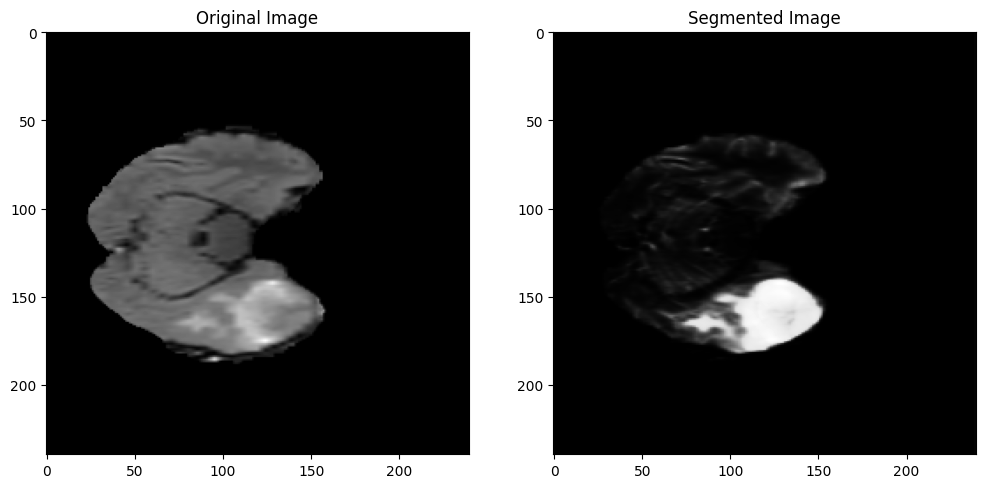

In [45]:

image_path1 = 'imagesTr/BRATS_001.nii.gz'
label_path1 = 'labelsTr/BRATS_001.nii.gz'
slice_index = 50
visualize_segmentation(image_path1, label_path2, slice_index)


## Segmentation Applied On Train Image2

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.9534 - loss: 0.6800 - val_accuracy: 1.0000 - val_loss: 0.6544
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.9948 - loss: 0.6025 - val_accuracy: 1.0000 - val_loss: 0.5649
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.9943 - loss: 0.4902 - val_accuracy: 1.0000 - val_loss: 0.4205
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.9948 - loss: 0.3666 - val_accuracy: 1.0000 - val_loss: 0.2532
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.9938 - loss: 0.2431 - val_accuracy: 1.0000 - val_loss: 0.1203
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.9942 - loss: 0.1349 - val_accuracy: 1.0000 - val_loss: 0.0485
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.9935 - loss: 0.0761 - val_accuracy: 1.0000 - val_loss: 0.0198
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.9933 - loss: 0.0481 - val_accuracy: 1.0000 - val_loss: 0.0091
Epoch 9/

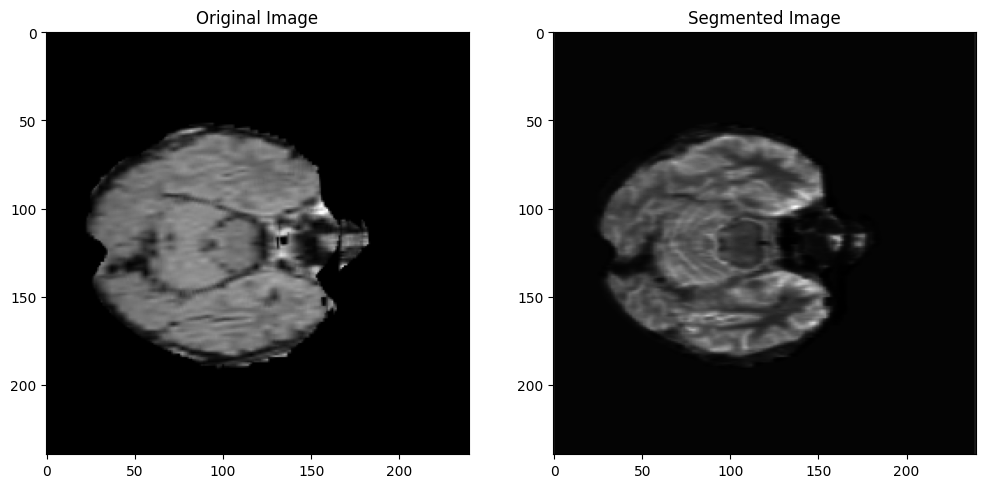

In [43]:

image_path2 = 'imagesTr/BRATS_002.nii.gz'
label_path2 = 'labelsTr/BRATS_002.nii.gz'
slice_index = 50
visualize_segmentation(image_path2, label_path2, slice_index)

## Segmentation Applied On Train Image3

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.9821 - loss: 0.6777 - val_accuracy: 1.0000 - val_loss: 0.6519
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.9824 - loss: 0.6122 - val_accuracy: 1.0000 - val_loss: 0.5620
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.9849 - loss: 0.5170 - val_accuracy: 1.0000 - val_loss: 0.4231
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.9840 - loss: 0.4045 - val_accuracy: 1.0000 - val_loss: 0.2636
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.9853 - loss: 0.2650 - val_accuracy: 1.0000 - val_loss: 0.1284
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.9862 - loss: 0.1431 - val_accuracy: 1.0000 - val_loss: 0.0514
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.9851 - loss: 0.0797 - val_accuracy: 1.0000 - val_loss: 0.0192
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.9834 - loss: 0.0525 - val_accuracy: 1.0000 - val_loss: 0.0077
Epoch 9/

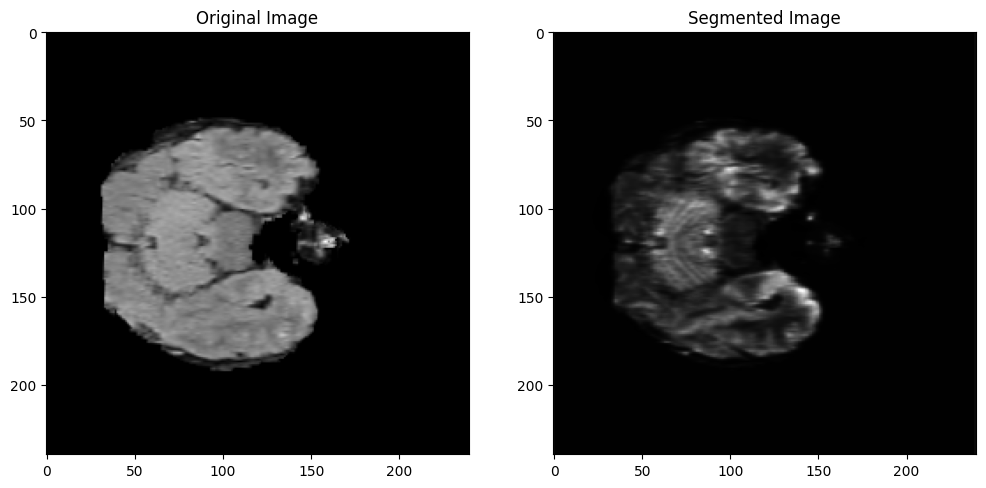

In [44]:


image_path3 = 'imagesTr/BRATS_003.nii.gz'
label_path3 = 'labelsTr/BRATS_003.nii.gz'
slice_index = 50
visualize_segmentation(image_path3, label_path3, slice_index)

## Applying UNet++ for Segmentation:

UNet++ is applied for segmenting brain images due to its effectiveness in capturing fine details and producing accurate segmentations. The steps involved in utilizing UNet++ for brain image segmentation are as follows:

Model Training: The prepared dataset is used to train the UNet++ model. Training involves feeding the model with input MRI images and their corresponding ground truth segmentation masks. The model learns to predict segmentation masks for unseen MRI images by minimizing the selected loss function.

Validation Set Evaluation: The UNet++ model's performance is tested on a separate set of data not seen during training to see how well it generalizes. This helps spot if the model is too specialized on the training data or if it's not learning enough.

Hyperparameter Tuning: Tweaks to settings like how quickly the model learns and its structure are made based on how well it does on the validation data. This fine-tuning helps improve the accuracy of brain segmentation.

Segmentation:After training and tuning, apply the UNet++ model to new brain MRI images. The model generates a segmentation map highlighting brain areas.

In [7]:
# UNet++ model
def unet_plusplus(input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Decoder
    up1 = UpSampling2D(size=(2, 2))(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(up1)
    concat1 = Concatenate()([conv2, conv1])

    # Additional convolutions for UNet++
    conv3 = Conv2D(64, 3, activation='relu', padding='same')(concat1)
    concat2 = Concatenate()([conv3, conv2, conv1])

    # Output
    outputs = Conv2D(1, 1, activation='sigmoid')(concat2)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [8]:
model = unet_plusplus((256, 256, 3))
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 256, 256,  │          0 │ max_pooling2d_1[… │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 256, 256,  │     36,928 │ up_sampling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256, 256,  │          0 │ conv2d_4[0][0],   │
│ (Concatenate)       │ 128)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 256, 256,  │     73,792 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 256, 256,  │          0 │ conv2d_5[0][0],   │
│ (Concatenate)       │ 192)              │            │ conv2d_4[0][0],   │
│                     │                   │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 256, 256,  │        193 │ concatenate_2[0]… │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 112,705 (440.25 KB)

 Trainable params: 112,705 (440.25 KB)

 Non-trainable params: 0 (0.00 B)

## Visualizing Segmentation Results

In [51]:
import matplotlib.pyplot as plt

# Function to visualize segmentation results
def visualize_segmentation(image_path, label_path, slice_index):
    # Load and preprocess data
    img_tr, label_tr, height, width, depth, channels = load_and_preprocess_data(image_path, label_path)

    # Create and train U-Net++ model
    model = unet_plusplus(input_shape=(height, width, channels))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(img_tr, label_tr, epochs=10, validation_split=0.2)

    # Predict segmentation mask for the original image
    segmentation_mask = model.predict(img_tr)

    # Plot original image and segmented image side by side
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_tr[:, :, slice_index, 0], cmap='gray')
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(segmentation_mask[:, :, slice_index, 0], cmap='gray')
    plt.title("Segmented Image")

    plt.show()


## Segmentation Applied On Train Image1

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.9822 - loss: 0.6735 - val_accuracy: 1.0000 - val_loss: 0.6124
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.9892 - loss: 0.5492 - val_accuracy: 1.0000 - val_loss: 0.3473
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 34s 6s/step - accuracy: 0.9896 - loss: 0.2936 - val_accuracy: 1.0000 - val_loss: 0.0592
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 59s 11s/step - accuracy: 0.9901 - loss: 0.0635 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 53s 9s/step - accuracy: 0.9935 - loss: 0.0154 - val_accuracy: 1.0000 - val_loss: 1.0248e-04
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 49s 8s/step - accuracy: 0.9922 - loss: 0.0118 - val_accuracy: 1.0000 - val_loss: 1.4191e-05
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 46s 8s/step - accuracy: 0.9927 - loss: 0.0037 - val_accuracy: 1.0000 - val_loss: 4.6725e-06
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 49s 8s/step - accuracy: 0.9921 - loss: -0.0082 - val_accuracy: 1.0000 - val_loss: 2

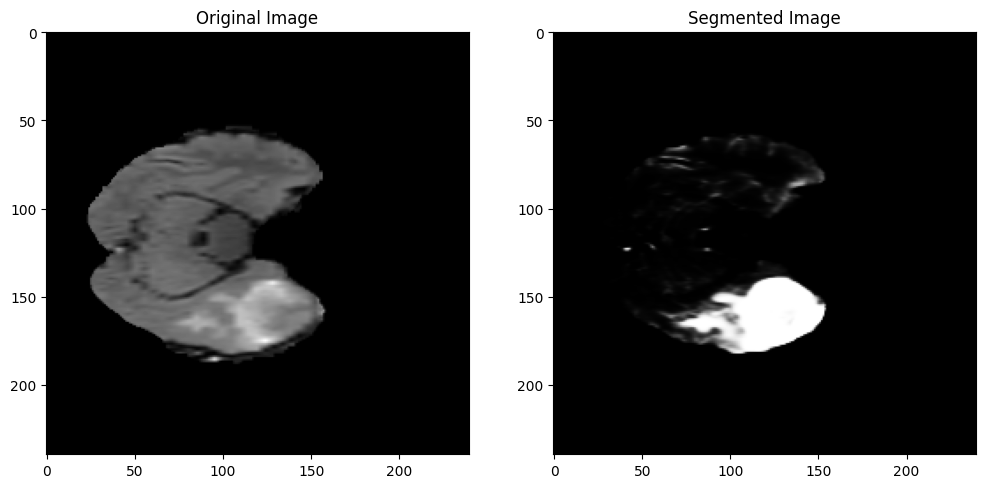

In [52]:

image_path1 = 'imagesTr/BRATS_001.nii.gz'
label_path1 = 'labelsTr/BRATS_001.nii.gz'
slice_index = 50
visualize_segmentation(image_path1, label_path1, slice_index)


## Segmentation Applied On Train Image2

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.9559 - loss: 0.6655 - val_accuracy: 1.0000 - val_loss: 0.6076
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 33s 6s/step - accuracy: 0.9948 - loss: 0.5111 - val_accuracy: 1.0000 - val_loss: 0.3069
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 53s 10s/step - accuracy: 0.9936 - loss: 0.2737 - val_accuracy: 1.0000 - val_loss: 0.0378
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 70s 11s/step - accuracy: 0.9937 - loss: 0.1234 - val_accuracy: 1.0000 - val_loss: 0.0035
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 55s 9s/step - accuracy: 0.9933 - loss: 0.0635 - val_accuracy: 1.0000 - val_loss: 9.5461e-04
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 58s 10s/step - accuracy: 0.9937 - loss: 0.0276 - val_accuracy: 1.0000 - val_loss: 3.7419e-04
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 52s 9s/step - accuracy: 0.9946 - loss: 0.0219 - val_accuracy: 1.0000 - val_loss: 1.6517e-04
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 53s 9s/step - accuracy: 0.9943 - loss: 0.0188 - val_accuracy: 1.0000 - val_loss: 

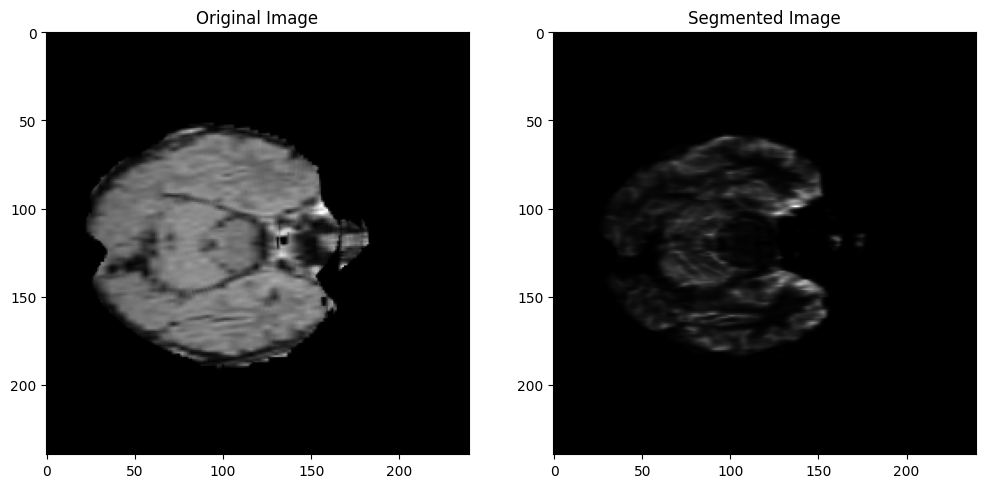

In [53]:

image_path2 = 'imagesTr/BRATS_002.nii.gz'
label_path2 = 'labelsTr/BRATS_002.nii.gz'
slice_index = 50
visualize_segmentation(image_path2, label_path2, slice_index)

## Segmentation Applied On Train Image3

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 53s 9s/step - accuracy: 0.9830 - loss: 0.6710 - val_accuracy: 1.0000 - val_loss: 0.6012
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 51s 9s/step - accuracy: 0.9868 - loss: 0.5291 - val_accuracy: 1.0000 - val_loss: 0.3041
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 52s 9s/step - accuracy: 0.9851 - loss: 0.2995 - val_accuracy: 1.0000 - val_loss: 0.0464
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 49s 8s/step - accuracy: 0.9827 - loss: 0.1411 - val_accuracy: 1.0000 - val_loss: 0.0053
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 49s 8s/step - accuracy: 0.9844 - loss: 0.0606 - val_accuracy: 1.0000 - val_loss: 9.8816e-04
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 48s 8s/step - accuracy: 0.9853 - loss: 0.0425 - val_accuracy: 1.0000 - val_loss: 2.4521e-04
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 49s 8s/step - accuracy: 0.9854 - loss: 0.0328 - val_accuracy: 1.0000 - val_loss: 8.6217e-05
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 48s 8s/step - accuracy: 0.9842 - loss: 0.0261 - val_accuracy: 1.0000 - val_loss: 3.6

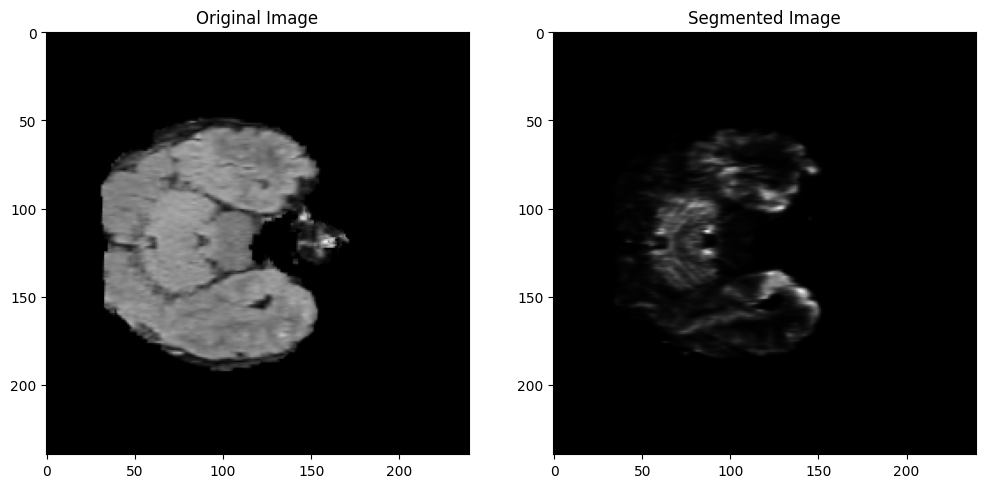

In [54]:

image_path3 = 'imagesTr/BRATS_003.nii.gz'
label_path3 = 'labelsTr/BRATS_003.nii.gz'
slice_index = 50
visualize_segmentation(image_path3, label_path3, slice_index)